## Imports and Constants

In [102]:
import pandas as pd
import json
import ipaddress
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
TRANSACTION_FRAUD_DATA_PATH = "./transaction_fraud_data.parquet"
HISTORICAL_CURRENCY_EXCHANGE_PATH = "./historical_currency_exchange.parquet"

## Download data

In [3]:
transaction_fraud_data = pd.read_parquet(TRANSACTION_FRAUD_DATA_PATH)
transaction_fraud_data.head(5)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [4]:
historical_currency_exchange = pd.read_parquet(HISTORICAL_CURRENCY_EXCHANGE_PATH)
historical_currency_exchange.head(5)

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


## Data Quality Assessment and Preprocessing

In [5]:
def null_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame summarizing null vs non-null counts and percentages per column.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to analyze.
    
    Returns
    -------
    pd.DataFrame
        Summary table indexed by column name with columns:
         - null_count
         - non_null_count
         - null_pct
         - non_null_pct
    """
    total = len(df)
    # Count nulls per column
    null_count = df.isnull().sum()
    # Compute non-nulls
    non_null_count = total - null_count
    # Build summary
    stats = pd.DataFrame({
        'null_count'     : null_count,
        'non_null_count' : non_null_count,
        'null_pct'       : (null_count / total * 100).round(2),
        'non_null_pct'   : (non_null_count / total * 100).round(2)
    })
    return stats

In [6]:
print(transaction_fraud_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [7]:
transaction_fraud_data_processed = transaction_fraud_data.copy()

In [8]:
"""
Проверяем содержание null значений в колонках датасета с транзакциями
"""
null_stats(transaction_fraud_data_processed)

,null_count,non_null_count,null_pct,non_null_pct
transaction_id,0,7483766,0.0,100.0
customer_id,0,7483766,0.0,100.0
card_number,0,7483766,0.0,100.0
timestamp,0,7483766,0.0,100.0
vendor_category,0,7483766,0.0,100.0
vendor_type,0,7483766,0.0,100.0
vendor,0,7483766,0.0,100.0
amount,0,7483766,0.0,100.0
currency,0,7483766,0.0,100.0
country,0,7483766,0.0,100.0


Датасет не имеет null значений в своих колонках.
<br>Что на самом деле редкая ситуация для real-world данных

In [ ]:
"""
По описанию данных в README.md можно сделать вывод,
что поле transaction_id является уникальным ключом в датасте transaction_fraud_data.

Проверим, что у значений этой колонки нет дублей.
"""

dupe_txns = transaction_fraud_data_processed['transaction_id'].duplicated().sum()
dupe_txns


np.int64(6460)

Исследуем строки с одинаковым ```transaction_id```.

Ожидается, что строки с одинаковыми ```transaction_id``` будут совпадать и по оставшимся полям.
<br> Тогда можно рассматривать их как дубли, и убрать из данных

In [10]:
def count_equal_unequal_rows(df: pd.DataFrame, group_col: str, columns_to_drop: list[str] = []):
    """
    Return a DataFrame summarizing counts of equal (identical) and unequal rows 
    for each duplicated value in the specified group column.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to analyze.
    
    group_col : str
        Name of the column to group by. The function will consider values in this column
        and identify duplicates, then compare the rest of the row contents within each group.

    columns_to_drop: list[str]
        Names of columns that should not be compared.

    Returns
    -------
    pd.DataFrame
        Summary table indexed by the duplicated values in `group_col`, with columns:
         - equal : int
             Number of repeated rows beyond the first occurrence (fully identical rows).
         - unequal : int
             Number of rows in the group that are not identical to any other row in that group.
    """
    # Only rows with duplicated values in group_col
    duplicated_df = df[df[group_col].duplicated(keep=False)]
    duplicated_df = duplicated_df.drop(labels=columns_to_drop, axis=1)

    # Apply inside each group
    def count_group(g):
        row_counts = g.value_counts()
        equal = sum(row_counts[row_counts > 1] - 1)
        unequal = len(g) - row_counts[row_counts > 1].sum()
        return pd.Series({'equal': equal, 'unequal': unequal})

    return duplicated_df.groupby(group_col).apply(count_group)

In [11]:
"""
Так поле last_hour_activity_json сотавное и имеет тип dict внури нашего data frame,
нам необходимо сделать его hashable копию, чтобы значения это колонки можно было сравнивать между собой.

Для этого сериализуем эту колонку в аналогичную, которая будет хранить json строки.
"""
transaction_fraud_data_processed['last_hour_activity_json'] = transaction_fraud_data_processed['last_hour_activity'].apply(lambda x: json.dumps(x, sort_keys=True))

In [12]:
row_stat = count_equal_unequal_rows(transaction_fraud_data_processed, 'transaction_id', ['last_hour_activity'])
row_stat

/var/folders/p2/skh823fd5t5fcl9_fbmxvw24rb6_10/T/ipykernel_64255/614493501.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return duplicated_df.groupby(group_col).apply(count_group)


,equal,unequal
transaction_id,,
TX_0003e9db,0,2
TX_0004e984,0,2
TX_0005b91b,0,2
TX_001a97b5,0,2
TX_0022820a,0,2
...,...,...
TX_ffc7fc2b,0,2
TX_ffcc6971,0,2
TX_ffdefa24,0,2


In [13]:
print(f'Кол-во различных transaction_id у которых нет разных строк: {len(row_stat[row_stat['unequal'] == 0])}')
print(f'Кол-во различных transaction_id у которых нет одинаковых строк: {len(row_stat[row_stat['equal'] == 0])}')
print(f'Набор значений для различных строк с одинаковым transaction_id:\n{list(row_stat['unequal'].unique())}')


Кол-во различных transaction_id у которых нет разных строк: 0
Кол-во различных transaction_id у которых нет одинаковых строк: 6453
Набор значений для различных строк с одинаковым transaction_id:
[np.int64(2), np.int64(3)]


In [14]:
# Рассмотри пример пары строк с одинаковым transaction_id
transaction_fraud_data_processed[transaction_fraud_data_processed['transaction_id'] == 'TX_0003e9db']

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,last_hour_activity_json
101374,TX_0003e9db,CUST_33598,5569939078731834,2024-09-30 11:21:11.618160,Retail,online,Etsy,1038.06,SGD,Singapore,...,Safari,web,4aa8dcbec2113fb024c9a68927bdd7fa,61.228.32.65,False,False,False,"{'num_transactions': 206, 'total_amount': 4965...",False,"{""max_single_amount"": 833420.6414852374, ""num_..."
1327891,TX_0003e9db,CUST_19259,375459469913771,2024-10-05 12:49:42.066906,Gas,major,Mobil,52909.46,JPY,Japan,...,Android App,mobile,f8f54159fd38e31b77e50c847fa7f3c5,245.196.10.182,False,False,True,"{'num_transactions': 1490, 'total_amount': 905...",False,"{""max_single_amount"": 3835974.1291076676, ""num..."


Мы видим, что у всех строк с повторяющимися ```transaction_id``` отличаются оставшиеся колонки.
<br>Это значит, что мы не можем брать поле ```transaction_id``` за уникальный идентификатор.

Добавим новую колонку, которая сможем служить уникальным идентификатором.
<br> Попробуем объеденить ```transaction_id``` и ```device_fingerprint```

In [ ]:
transaction_fraud_data_processed['custom_transaction_id'] = transaction_fraud_data['transaction_id'] + '_' + transaction_fraud_data['device_fingerprint']
col = transaction_fraud_data_processed.pop('custom_transaction_id')
transaction_fraud_data_processed.insert(0, 'custom_transaction_id', col)
transaction_fraud_data_processed.head()

,custom_transaction_id,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,...,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,last_hour_activity_json
0,TX_a0ad2a2a_e8e6160445c935fd0001501e4cbac8bc,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,...,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,"{""max_single_amount"": 1925480.6324148502, ""num..."
1,TX_3599c101_a73043a57091e775af37f252b3a32af9,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,...,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,"{""max_single_amount"": 5149117.011434267, ""num_..."
2,TX_a9461c6d_218864e94ceaa41577d216b149722261,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,...,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,"{""max_single_amount"": 1852242.1831665323, ""num..."
3,TX_7be21fc4_70423fa3a1e74d01203cf93b51b9631d,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,...,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False,"{""max_single_amount"": 2055798.460682913, ""num_..."
4,TX_150f490b_9880776c7b6038f2af86bd4e18a1b1a4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,...,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True,"{""max_single_amount"": 1157231.252130005, ""num_..."


In [ ]:
# проверим, что новое поле не содержит дубликатов
dupe_custom_txns = transaction_fraud_data_processed['custom_transaction_id'].duplicated().sum()
dupe_custom_txns

np.int64(0)

### Проверка категориальных полей

In [34]:
def get_uniq_category_field_values(df: pd.DataFrame, categ_columns: list[str]):
    for cc in categ_columns:
        print(f"Уникальные значения колонки {cc}:")
        print(df[cc].unique().tolist())
        print()

In [37]:
print("Колонки, относящиеся к информации о вендоре:\n")
vendor_categ_columns = [
    "vendor_category",
    "vendor_type",
    "vendor"
]
get_uniq_category_field_values(transaction_fraud_data_processed, categ_columns)

Колонки, относящиеся к информации о вендоре:

Уникальные значения колонки vendor_category:
['Restaurant', 'Entertainment', 'Grocery', 'Gas', 'Healthcare', 'Education', 'Travel', 'Retail']

Уникальные значения колонки vendor_type:
['fast_food', 'gaming', 'physical', 'major', 'medical', 'online', 'hotels', 'pharmacy', 'premium', 'events', 'supplies', 'airlines', 'local', 'booking', 'streaming', 'transport', 'casual']

Уникальные значения колонки vendor:
['Taco Bell', 'Steam', 'Whole Foods', 'Exxon', 'Medical Center', 'Coursera', 'Instacart', 'Westin', 'eBay', 'DuaneReade', 'Nobu', 'FreshDirect', 'StubHub', 'University Bookstore', 'American Airlines', 'Home Depot', "Morton's", 'Ticketmaster', 'Skillshare', 'Local Gas Station', 'Texaco', 'Hotels.com', 'Walmart Grocery', 'Epic Games', 'AMC Theaters', 'Etsy', 'IKEA', 'Costco', 'Spotify', 'Capital Grille', "Trader Joe's", 'Urgent Care', 'Careem', "Wendy's", "Macy's", 'Udemy', 'Target', 'Truck Stop', 'BP', 'TGI Fridays', 'Chevron', 'Amazon', '

In [42]:
print("Валюта:\n")
currency_categ_columns = ["currency"]
get_uniq_category_field_values(transaction_fraud_data_processed, currency_categ_columns)
print()
print('Валюты с известынм курсом:')
print(historical_currency_exchange.columns.to_list()[1:])

Валюта:

Уникальные значения колонки currency:
['GBP', 'BRL', 'JPY', 'AUD', 'NGN', 'EUR', 'MXN', 'RUB', 'CAD', 'SGD', 'USD']


Валюты с известынм курсом:
['AUD', 'BRL', 'CAD', 'EUR', 'GBP', 'JPY', 'MXN', 'NGN', 'RUB', 'SGD', 'USD']


In [44]:
print("Проверка гео фичей:\n")
geo_categ_columns = ['country', 'city', 'city_size']
get_uniq_category_field_values(transaction_fraud_data_processed, geo_categ_columns)

Проверка гео фичей:

Уникальные значения колонки country:
['UK', 'Brazil', 'Japan', 'Australia', 'Nigeria', 'Germany', 'Mexico', 'Russia', 'France', 'Canada', 'Singapore', 'USA']

Уникальные значения колонки city:
['Unknown City', 'San Antonio', 'Philadelphia', 'Phoenix', 'San Diego', 'Los Angeles', 'Chicago', 'Dallas', 'New York', 'San Jose', 'Houston']

Уникальные значения колонки city_size:
['medium', 'large']



Можно заметить, что определены только некоторые города из USA.

In [47]:
def check_ip_version(ip):
    try:
        ip_obj = ipaddress.ip_address(ip)
        return 'IPv4' if isinstance(ip_obj, ipaddress.IPv4Address) else 'IPv6'
    except ValueError:
        return 'Invalid'

In [48]:
# Проверим корректность указанных IP адресов
ip_versions = transaction_fraud_data_processed['ip_address'].apply(check_ip_version)
ip_versions.unique().tolist()

['IPv4']

In [50]:
# Проверим содержание фродовых транзакций в датасете.

total_tr = len(transaction_fraud_data_processed)
fraud_tr = len(transaction_fraud_data_processed[transaction_fraud_data_processed['is_fraud'] == 1])

print(f'Кол-во различных транзакций всего: {total_tr}')
print(f'Кол-во фродовых транзакций: {fraud_tr}')
print(f'% фродовых транзакций: {round(fraud_tr / total_tr, 4) * 100}%')




Кол-во различных транзакций всего: 7483766
Кол-во фродовых транзакций: 1494719
% фродовых транзакций: 19.97%


Можно заметить, что почти 1/5 всех транзакций - фродовые.
<br> Поэтому мы **не можем** назвать наш датасет highly unbalanced

### Проверка количественных полей

In [52]:
print(f'Самая старая транзакция:{transaction_fraud_data_processed['timestamp'].min()}')
print(f'Самая новая транзакция:{transaction_fraud_data_processed['timestamp'].max()}')


Самая старая транзакция:2024-09-30 00:00:01.034820
Самая новая транзакция:2024-10-30 23:59:59.101885


Период охватывает один календарный месяц и выглядит реалистично.
<br> В тоже время, это ограничивает возможность анализа сезонных колебаний в разрезе времён года или лет.

In [54]:
def convert_to_usd(row):
    currency = row['currency']
    amount = row['amount']
    
    # If already in USD, no conversion needed
    if currency == 'USD':
        return amount
    
    # Get the exchange rate for the currency
    # If exchange rate is how many units of currency equal 1 USD
    if currency in row and pd.notna(row[currency]):
        return amount / row[currency]
    else:
        # Handle missing exchange rates
        return None

In [56]:
# Проверка диапазона суммы транзакции

# Для начала конфертируем все суммы в доллары:
transaction_fraud_data_processed['date'] = transaction_fraud_data_processed['timestamp'].dt.date

merged_data = pd.merge(
    transaction_fraud_data_processed, 
    historical_currency_exchange, 
    on='date', 
    how='left'
)
merged_data['amount_usd'] = merged_data.apply(convert_to_usd, axis=1)
merged_data.columns

Index(['custom_transaction_id', 'transaction_id', 'customer_id', 'card_number',
       'timestamp', 'vendor_category', 'vendor_type', 'vendor', 'amount',
       'currency', 'country', 'city', 'city_size', 'card_type',
       'is_card_present', 'device', 'channel', 'device_fingerprint',
       'ip_address', 'is_outside_home_country', 'is_high_risk_vendor',
       'is_weekend', 'last_hour_activity', 'is_fraud',
       'last_hour_activity_json', 'date', 'AUD', 'BRL', 'CAD', 'EUR', 'GBP',
       'JPY', 'MXN', 'NGN', 'RUB', 'SGD', 'USD', 'amount_usd'],
      dtype='object')

In [57]:
transaction_fraud_data_processed = merged_data[transaction_fraud_data_processed.columns.to_list() + ['amount_usd']].copy()
transaction_fraud_data_processed.columns


Index(['custom_transaction_id', 'transaction_id', 'customer_id', 'card_number',
       'timestamp', 'vendor_category', 'vendor_type', 'vendor', 'amount',
       'currency', 'country', 'city', 'city_size', 'card_type',
       'is_card_present', 'device', 'channel', 'device_fingerprint',
       'ip_address', 'is_outside_home_country', 'is_high_risk_vendor',
       'is_weekend', 'last_hour_activity', 'is_fraud',
       'last_hour_activity_json', 'date', 'amount_usd'],
      dtype='object')

In [58]:
print(f'Минимальная сумма транзакции: {round(transaction_fraud_data_processed['amount_usd'].min(), 2)}$')
print(f'Максимальная сумма транзакции: {round(transaction_fraud_data_processed['amount_usd'].max(), 2)}$')

Минимальная сумма транзакции: 0.0$
Максимальная сумма транзакции: 15781.54$


Диапазон суммы транзакции выглядит реалистично

**Основные выводы после стадии Data Quality Assessment and Preprocessing**

- В датасете нет null значений

- В датасете содержатся отличающиеся строки, но с одинаковым ```transaction_id```.
<br>Для создания уникального идентификатора мы создали поле = ```transaction_id``` + ```device_fingerprint```

- Добавил поле ```amount_usd```, которое равно ```amount``` в долларах

- Поле ```city``` содержит названия только нескольких американских городов, остальные помечены как 'Unknown City'

- Датасеты содержит информацию о транзакциях с 2024-09-30 по 2024-10-30

- Примерно 1/5 датасета это фродовые транзакции


## Data analysis and visualisation

Так как датасет сожержит довольно большое кол-во фродовых транзакций, дальнейший анализ будет проводиться в разрезе двух категорий: фрод и не фрод

#### Гео анализ

In [68]:
uniq_countries = transaction_fraud_data_processed['country'].unique()
print(f"Кол-во стран: {len(uniq_countries)}")
uniq_countries.tolist()

Кол-во стран: 12


['UK',
 'Brazil',
 'Japan',
 'Australia',
 'Nigeria',
 'Germany',
 'Mexico',
 'Russia',
 'France',
 'Canada',
 'Singapore',
 'USA']

In [63]:
# Group by country to get total and fraud counts
country_stats = (
    transaction_fraud_data_processed
      .groupby('country', as_index=False)
      .agg(
          total_txns=('custom_transaction_id','count'),
          fraud_txns=('is_fraud','sum'),
      )
)

# Calculate fraud rate as a percentage
country_stats['fraud_rate'] = country_stats['fraud_txns'] / country_stats['total_txns'] * 100
country_stats['txns_rate'] = country_stats['total_txns'] / len(transaction_fraud_data_processed) * 100


Топ 5 стран по % фродовых транзакций

In [64]:
country_stats.sort_values(['fraud_rate'], ascending=False).head()

,country,total_txns,fraud_txns,fraud_rate,txns_rate
6,Mexico,785704,298841,38.034807,10.498778
8,Russia,793730,299425,37.723785,10.606024
1,Brazil,804800,298629,37.105989,10.753944
7,Nigeria,849840,298600,35.136026,11.355780
0,Australia,496695,37652,7.580507,6.636966


Топ 5 стран по % транзакций от общего числа

In [67]:
country_stats.sort_values(['txns_rate'], ascending=False).head()

,country,total_txns,fraud_txns,fraud_rate,txns_rate
7,Nigeria,849840,298600,35.136026,11.355780
1,Brazil,804800,298629,37.105989,10.753944
8,Russia,793730,299425,37.723785,10.606024
6,Mexico,785704,298841,38.034807,10.498778
9,Singapore,588668,37414,6.355705,7.865933


In [ ]:
country_name_map = {
    'UK': 'United Kingdom',
    'USA': 'United States',
    'Brazil': 'Brazil',
    'Japan': 'Japan',
    'Australia': 'Australia',
    'Nigeria': 'Nigeria',
    'Germany': 'Germany',
    'Mexico': 'Mexico',
    'Russia': 'Russia',
    'France': 'France',
    'Canada': 'Canada',
    'Singapore': 'Singapore'
}

In [72]:
fig = px.choropleth(
    country_stats,
    locations='country',            # column with country names
    locationmode='country names',   # tells Plotly to match on names
    color='fraud_rate',             # value to color by
    hover_name='country',           # what shows on hover
    hover_data={
        'total_txns': True,
        'fraud_txns': True,
        'fraud_rate': ':.2f',        # two‐decimal formatting
        'txns_rate': ':.2f'
    },
    color_continuous_scale='Reds',
    title='Interactive Map: Fraud Rate by Country'
)

In [73]:
fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),    # remove extra padding
    coloraxis_colorbar=dict(
        title="Fraud Rate (%)",
        tickformat=".1f"
    )
)


Данная интерактивная карта наглядно отображает страны с наибольшим процентым фродовых транзакций в рамках данного набора данных.

In [ ]:
def plot_country_mixed(country_stats: pd.DataFrame,
                       top_n: int = 10,
                       figsize: tuple = (12, 6),
                       bar_color: str = '#4c72b0',
                       line_color: str = '#c44e52'):
    """
    Plot a mixed bar + line chart for country transaction stats.

    Parameters
    ----------
    country_stats : pd.DataFrame
        DataFrame with columns:
          - 'country'
          - 'total_txns'
          - 'fraud_rate'
    top_n : int, default=10
        Number of top countries (by total_txns) to display.
    figsize : tuple, default=(12,6)
        Figure size.
    bar_color : str, default='#4c72b0'
        Color for the bar chart.
    line_color : str, default='#c44e52'
        Color for the fraud_rate line.
    """
    # Select top N by total transactions
    df = (country_stats
          .sort_values('total_txns', ascending=False)
          .head(top_n)
          .reset_index(drop=True))
    
    # Create figure and first axis
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Bar plot: total transactions
    sns.barplot(
        x='country', y='total_txns',
        data=df, ax=ax1,
        color=bar_color
    )
    ax1.set_ylabel('Total Transactions', color=bar_color, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=bar_color)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Second y-axis: fraud rate line
    ax2 = ax1.twinx()
    sns.lineplot(
        x='country', y='fraud_rate',
        data=df, ax=ax2,
        sort=False,                # keep same order as bars
        marker='o', linewidth=2.5,
        color=line_color
    )
    ax2.set_ylabel('Fraud Rate (%)', color=line_color, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=line_color)
    
    # Title and layout
    plt.title(f'Top {top_n} Countries: Transactions vs Fraud Rate', fontsize=14)
    plt.tight_layout()
    plt.show()


/var/folders/p2/skh823fd5t5fcl9_fbmxvw24rb6_10/T/ipykernel_64255/689865979.py:42: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



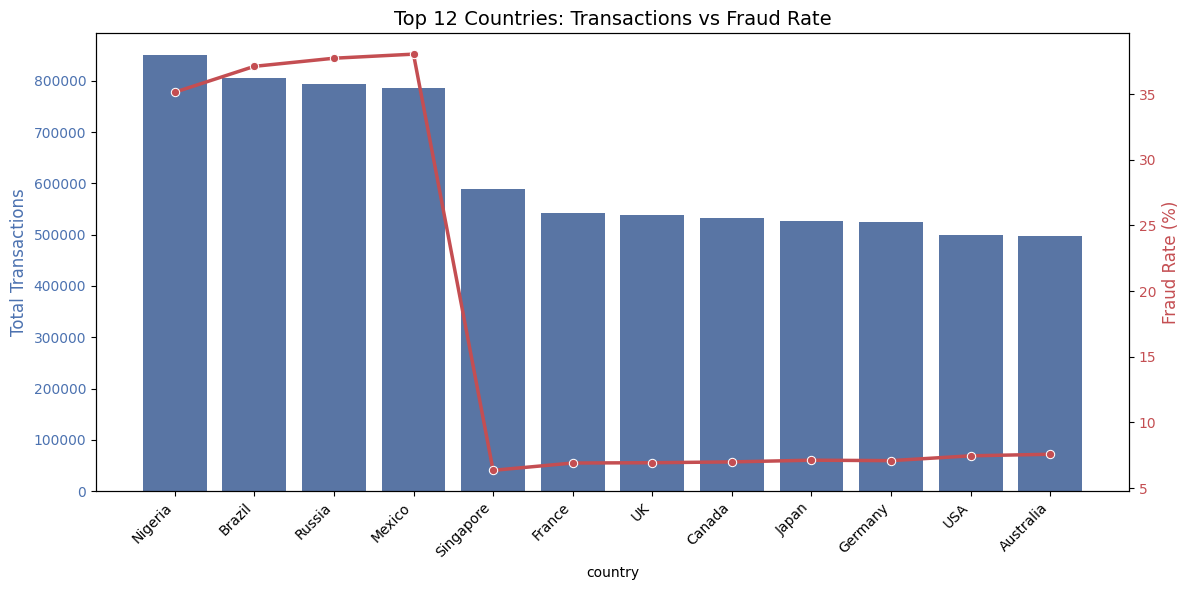

In [76]:
plot_country_mixed(country_stats, top_n = len(uniq_countries))

In [79]:
top_fraud_countries = country_stats.sort_values(['fraud_rate'], ascending=False)['country'].to_list()[:4]
top_fraud_countries

['Mexico', 'Russia', 'Brazil', 'Nigeria']

Эта смешанная диграмма хорошо подчеркивает, что страны делятся на две группы:

1. Страны с наибольшим общим кол-вом транзакций и с высоким процентом фрода

2. Чуть менее представленные, но при этом так же примерно в равной степени, страны с относительно низким процентом фрода


Так же можно предположить, что датасет имеет смещение в сторону развивающихся стран, а не развитых, так как в данном наборе данных большее кол-во транзакци относится к странам латинской америки, африки и России.

При этом исследование[1] World Bank Group за 2025ый год утверждает о том, что значительный объем всех транзакций принадлежит развитым странам, в особенности странам европы, UK и USA, а также Китай.
<br>[1] https://www.worldbank.org/en/publication/globalfindex

#### Анализ по типу вендора, ```vendor_type```

In [80]:
# Group by vendor_type
vt_stats = (
    transaction_fraud_data_processed
    .groupby('vendor_type', as_index=False)
    .agg(
        total_txns=('custom_transaction_id','count'),
        fraud_txns=('is_fraud','sum')
    )
)

vt_stats_in_fraud_countries = (
    transaction_fraud_data_processed[transaction_fraud_data_processed['country'].isin(top_fraud_countries)]
    .groupby('vendor_type', as_index=False)
    .agg(
        total_txns=('custom_transaction_id','count'),
        fraud_txns=('is_fraud','sum')
    )
)

# Calculate fraud rate and transaction rate as a percentage
vt_stats['fraud_rate'] = vt_stats['fraud_txns'] / vt_stats['total_txns'] * 100
vt_stats['txns_rate'] = vt_stats['total_txns'] / len(transaction_fraud_data_processed) * 100

vt_stats_in_fraud_countries['fraud_rate'] = vt_stats_in_fraud_countries['fraud_txns'] / vt_stats_in_fraud_countries['total_txns'] * 100
vt_stats_in_fraud_countries['txns_rate'] = vt_stats_in_fraud_countries['total_txns'] / len(transaction_fraud_data_processed[transaction_fraud_data_processed['country'].isin(top_fraud_countries)]) * 100

Топ 10 типов вендоров по % фродовых транзакций:

In [96]:
vt_stats.sort_values(['fraud_rate'], ascending=False).head(10)

,vendor_type,total_txns,fraud_txns,fraud_rate,txns_rate
16,transport,233977,47069,20.116935,3.126461
4,fast_food,312805,62786,20.071930,4.179781
0,airlines,233476,46820,20.053453,3.119766
12,physical,935039,187200,20.020555,12.494231
1,booking,234026,46846,20.017434,3.127115
3,events,312598,62525,20.001727,4.177015
8,major,467499,93416,19.982075,6.246841
11,pharmacy,468377,93569,19.977283,6.258574
15,supplies,466765,93240,19.975791,6.237034
7,local,467902,93413,19.964223,6.252226


Тоже самое, но в разере стран с наибольшим процентом фрода:

In [94]:
vt_stats_in_fraud_countries.sort_values(['fraud_rate'], ascending=False).head(10)

,vendor_type,total_txns,fraud_txns,fraud_rate,txns_rate
3,events,135166,50231,37.162452,4.179434
16,transport,101461,37680,37.137422,3.137250
11,pharmacy,202080,74882,37.055622,6.248466
12,physical,404576,149799,37.026171,12.509794
1,booking,100787,37316,37.024616,3.116410
13,premium,134888,49881,36.979568,4.170838
10,online,605510,223811,36.962395,18.722825
4,fast_food,135243,49975,36.952005,4.181815
15,supplies,202156,74688,36.945725,6.250816
7,local,202130,74677,36.945035,6.250012


Топ 10 типов вендоров по % от общего кол-ва транзакций:

In [83]:
vt_stats.sort_values(['txns_rate'], ascending=False).head(10)

,vendor_type,total_txns,fraud_txns,fraud_rate,txns_rate
10,online,1401650,279363,19.931010,18.729207
12,physical,935039,187200,20.020555,12.494231
9,medical,468393,93200,19.897821,6.258787
11,pharmacy,468377,93569,19.977283,6.258574
7,local,467902,93413,19.964223,6.252226
8,major,467499,93416,19.982075,6.246841
15,supplies,466765,93240,19.975791,6.237034
4,fast_food,312805,62786,20.071930,4.179781
3,events,312598,62525,20.001727,4.177015
14,streaming,312091,62206,19.932007,4.170240


Тоже самое, но в разере стран с наибольшим процентом фрода:

In [84]:
vt_stats_in_fraud_countries.sort_values(['txns_rate'], ascending=False).head(10)

,vendor_type,total_txns,fraud_txns,fraud_rate,txns_rate
10,online,605510,223811,36.962395,18.722825
12,physical,404576,149799,37.026171,12.509794
8,major,202258,74607,36.887045,6.253969
15,supplies,202156,74688,36.945725,6.250816
7,local,202130,74677,36.945035,6.250012
11,pharmacy,202080,74882,37.055622,6.248466
9,medical,201835,74422,36.872693,6.240890
4,fast_food,135243,49975,36.952005,4.181815
3,events,135166,50231,37.162452,4.179434
13,premium,134888,49881,36.979568,4.170838


In [100]:
def compare_vendor_type_scatter2(vt_all, vt_fraud_ctrs,
                                figsize=(14, 6),
                                palette="tab20"):
    # Get list of vendor_types and a matching color palette
    vendor_types = vt_all['vendor_type'].unique()
    colors = sns.color_palette(palette, len(vendor_types))
    pal = dict(zip(vendor_types, colors))
    
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    for ax, df, title in zip(
        axes,
        [vt_all, vt_fraud_ctrs],
        ["All Countries", "Top Fraud Countries"]
    ):
        sns.scatterplot(
            data=df,
            x="total_txns", y="fraud_rate",
            hue="vendor_type", palette=pal,
            s=100, ax=ax,
            edgecolor="w", linewidth=0.5,
            legend=False        # <-- turn off per-axis legend
        )
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Total Transactions", fontsize=12)
        ax.set_ylabel("Fraud Rate (%)", fontsize=12)
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
        ax.xaxis.set_tick_params(rotation=45)
        if ax is axes[1]:
            ax.yaxis.set_ticks_position("right")
            ax.yaxis.set_label_position("right")
            ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:.0f}%"))
        else:
            ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:.0f}"))
    
    # Build a single legend at the bottom
    handles = [
        Line2D([0], [0], marker="o", color="w",
               markerfacecolor=pal[vt], markersize=8)
        for vt in vendor_types
    ]
    fig.legend(
        handles, vendor_types,
        title="Vendor Type",
        loc="lower center",
        ncol=5,
        frameon=False,
        bbox_to_anchor=(0.5, -0.05)
    )
    
    plt.suptitle("Vendor Type: Volume vs Fraud Rate", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

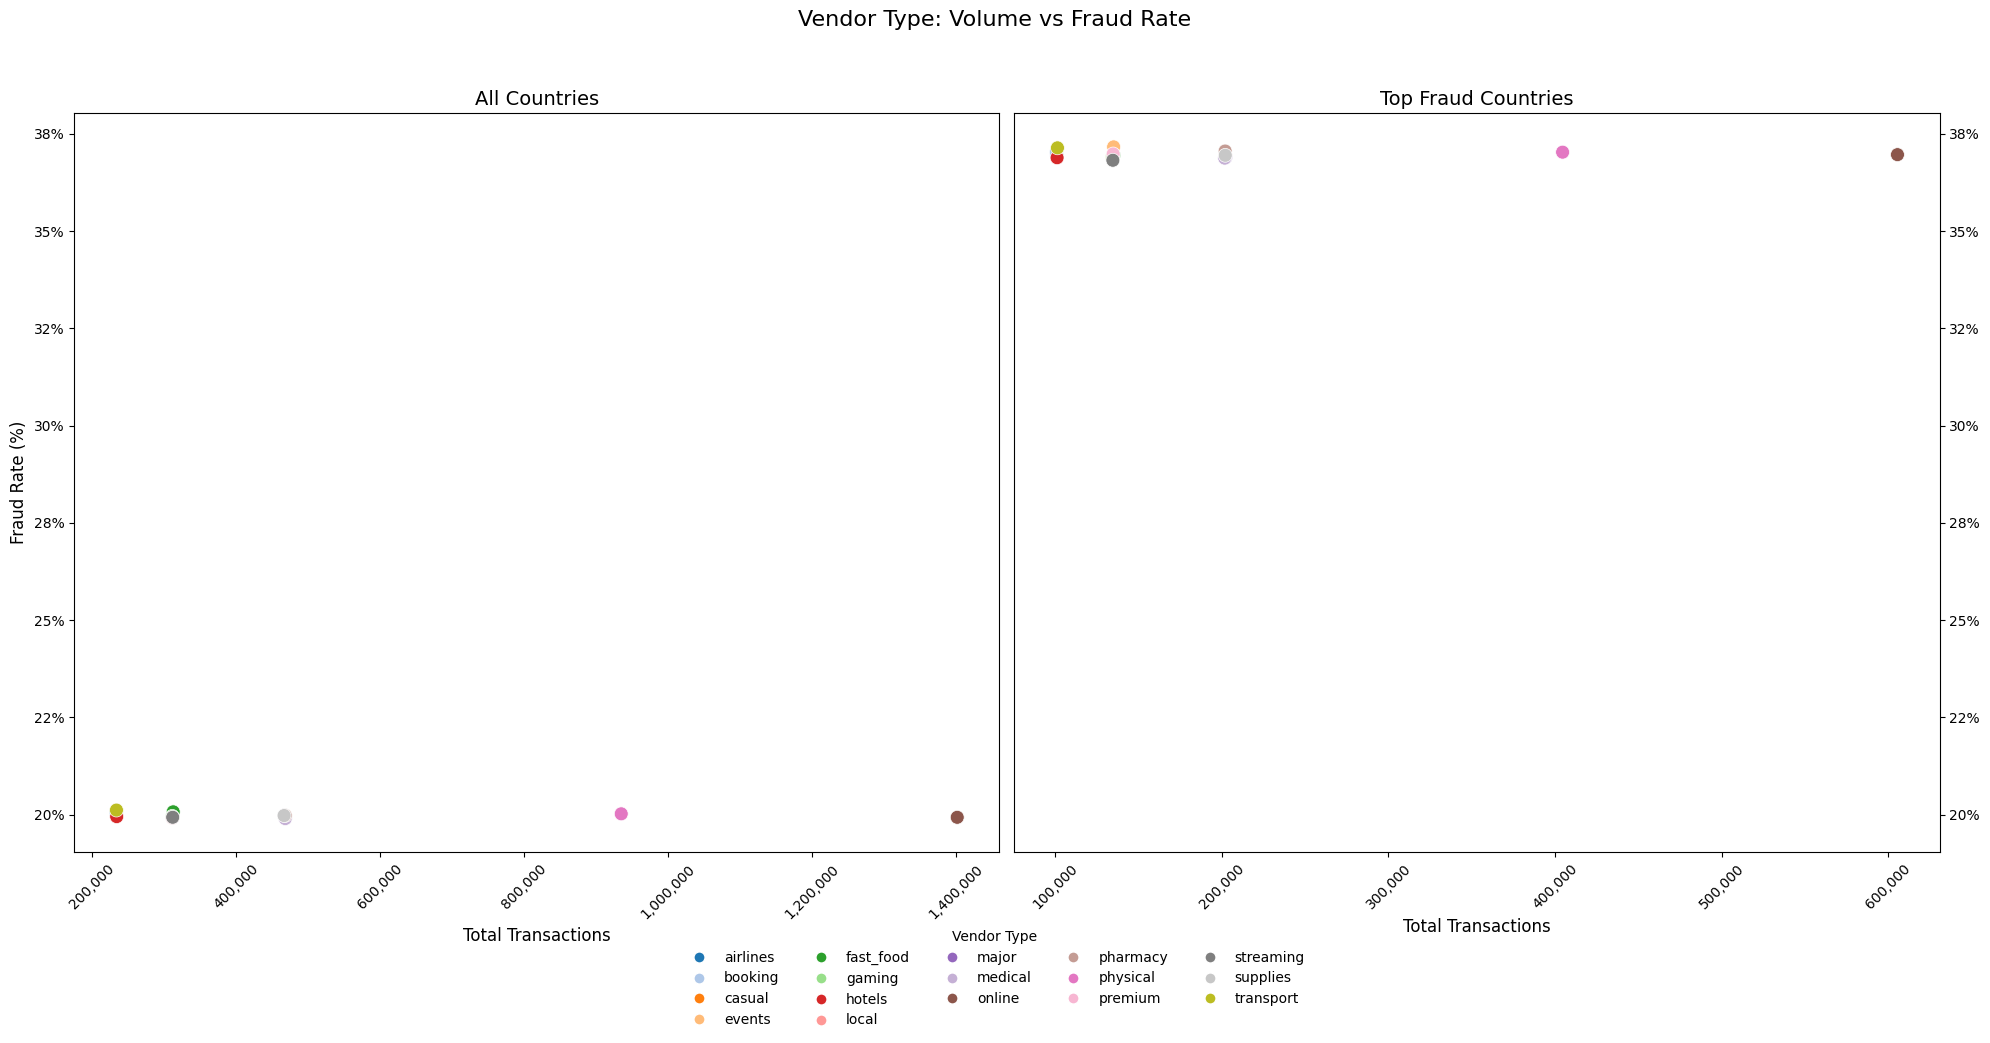

In [103]:
compare_vendor_type_scatter2(vt_stats, vt_stats_in_fraud_countries, figsize=(20, 10))

Данная диаграмма рассеяния демонстриурет неочевидный результат.

По кол-ву транзакций в целом, можно выделить два одназначных лидера: online и physical.
<br> Но, что интересно, % фродовых транзакций распределен по типам вендоров равномерно.
<br>Такое распределение выглдяит не очень естесвенно.

#### Анализ сумм транзакций, ```amount_usd```

Посмторим на топ 20 самых больших транзакций среди всех:

In [105]:
top_tx = (
    transaction_fraud_data_processed
    .sort_values('amount_usd', ascending=False)
    .head(20)
    [['transaction_id','customer_id','amount_usd','country','vendor_type','is_fraud']]
)
top_tx

,transaction_id,customer_id,amount_usd,country,vendor_type,is_fraud
2931774,TX_33de8275,CUST_84744,15781.540993,Mexico,booking,True
1730096,TX_e4a38519,CUST_61661,15757.587128,Mexico,booking,True
1953489,TX_14d04f46,CUST_91532,15720.078490,Mexico,booking,True
208083,TX_8a13a5a6,CUST_58337,15693.767745,Singapore,booking,True
3402759,TX_33105936,CUST_52188,15682.188327,Singapore,booking,True
4116687,TX_52d49192,CUST_34751,15668.539655,Singapore,booking,True
3482562,TX_3e010d82,CUST_62056,15641.360167,Mexico,booking,True
3165906,TX_ef261221,CUST_54779,15640.579675,Singapore,booking,True
2184804,TX_684fe19a,CUST_56683,15634.910798,Mexico,booking,True
1800272,TX_14459b5d,CUST_57338,15609.087610,Mexico,booking,True


Интересно заметить, что всег транзакции фродовые

Посмотрим на распределение сумм в целом

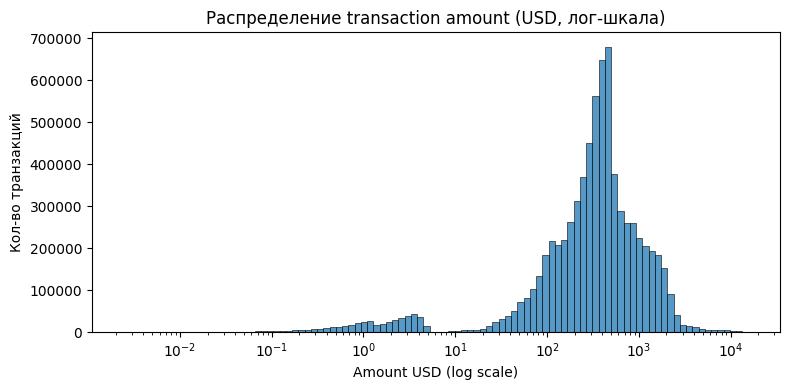

In [109]:
plt.figure(figsize=(8,4))
sns.histplot(
    data=transaction_fraud_data_processed,
    x='amount_usd',
    bins=100,
    log_scale=(True, False),  # X-лог-шкала
    kde=False
)
plt.title('Распределение transaction amount (USD, лог-шкала)')
plt.xlabel('Amount USD (log scale)')
plt.ylabel('Кол-во транзакций')
plt.tight_layout()
plt.show()

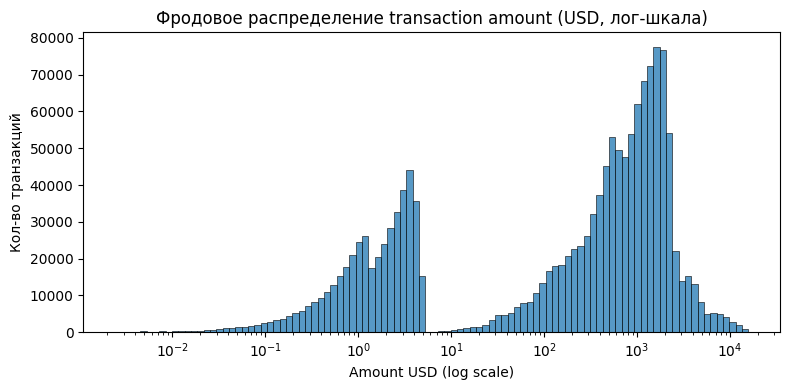

In [110]:
plt.figure(figsize=(8,4))
sns.histplot(
    data=transaction_fraud_data_processed[transaction_fraud_data_processed['is_fraud'] == 1],
    x='amount_usd',
    bins=100,
    log_scale=(True, False),  # X-лог-шкала
    kde=False
)
plt.title('Фродовое распределение transaction amount (USD, лог-шкала)')
plt.xlabel('Amount USD (log scale)')
plt.ylabel('Кол-во транзакций')
plt.tight_layout()
plt.show()

In [111]:
def plot_amount_boxplots(df, amount_col='amount_usd', log_scale=True, figsize=(10, 6)):
    """
    Plot side-by-side boxplots of transaction amounts:
      - Left: all transactions
      - Right: only fraud transactions

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least:
          - amount_col (numeric)
          - 'is_fraud' (boolean or 0/1)
    amount_col : str, default='amount_usd'
        Column name for the transaction amount.
    log_scale : bool, default=True
        If True, set the y-axis to log scale.
    figsize : tuple, default=(10,6)
        Figure size (width, height).
    """
    # Split data
    all_amt   = df[amount_col]
    fraud_amt = df.loc[df['is_fraud'] == 1, amount_col]

    # Prepare subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Left: all transactions
    sns.boxplot(
        y=all_amt,
        ax=axes[0],
        showfliers=False  # hide extreme outliers for clarity
    )
    axes[0].set_title('All Transactions')
    axes[0].set_xlabel('')
    axes[0].set_ylabel(amount_col.replace('_', ' ').title())

    # Right: fraud transactions
    sns.boxplot(
        y=fraud_amt,
        ax=axes[1],
        showfliers=False
    )
    axes[1].set_title('Fraud Transactions')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')

    # Apply log scale if requested
    if log_scale:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
        # optional: adjust ticks
        for ax in axes:
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _:
                f"{int(y):,}" if y >= 1 else f"{y:.2f}"
            ))

    # Layout tweaks
    plt.suptitle('Transaction Amount Distribution', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

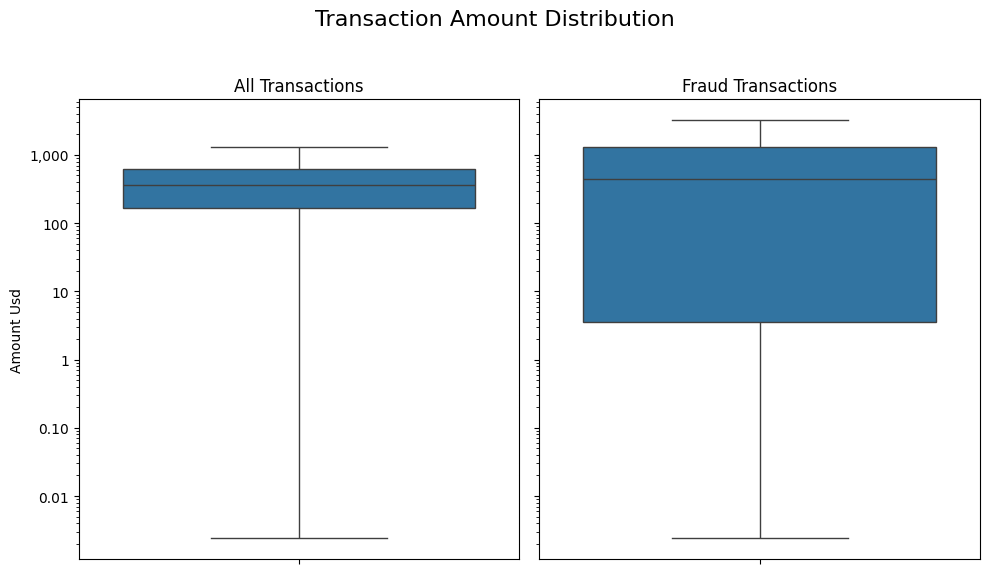

In [112]:
plot_amount_boxplots(transaction_fraud_data_processed)

Гистограммы и бокс плоты визуализируют разницу в распределении сумм транзакций.

Мы видим, что для фродовых транзакций характерны экстримальные значения.
<br>В том время как транзакции в целом обычно имеют размер от сотни до тысчи долларов

## Предлагаемые гипотезы